In [47]:
import csv
import os
import pandas as pd

def fixpath(path):
    if path.startswith("C:"): return "/mnt/c/" + path.replace("\\", "/")[3:]
    else:
        pass
    return path

os.chdir(fixpath(r'C:\Users\smoha\Documents\git\copper\COPPER7'))

coordinate_df = pd.read_excel("coordinate.xlsx", sheet_name="coordinate_system")

coordinate_BC = coordinate_df.loc[coordinate_df['PRENAME'] == 'British Columbia']
coordinate_AB = coordinate_df.loc[coordinate_df['PRENAME'] == 'Alberta']
test = coordinate_BC.loc[:,'grid cell']

#windcf = pd.read_csv('windcf.csv')
#solarcf = pd.read_csv('solarcf.csv')

with open('windcf.csv') as csv_file:
    reader = csv.reader(csv_file)
    windcf = dict(reader)

for k in windcf:
    windcf[k]=float(windcf[k])

with open('solarcf.csv') as csv_file:
    reader = csv.reader(csv_file)
    solarcf = dict(reader)

for k in solarcf:
    solarcf[k]=float(solarcf[k])

In [ ]:
windcf_BC = pd.DataFrame()
solarcf_BC = pd.DataFrame()
windcf_AB = pd.DataFrame()
solarcf_AB = pd.DataFrame()

for i, row in coordinate_BC.iterrows():
    grid_cell = int(row['grid cell'])
    wind_list = []
    solar_list = []
    for j in range(1, 8761):
        wind_list.append(windcf[str(j) + '.' + str(grid_cell)])
        solar_list.append(solarcf[str(j) + '.' + str(grid_cell)])

    windcf_BC[grid_cell] = wind_list
    solarcf_BC[grid_cell] = solar_list

for i, row in coordinate_AB.iterrows():
    grid_cell = int(row['grid cell'])
    wind_list = []
    solar_list = []
    for j in range(1, 8761):
        wind_list.append(windcf[str(j) + '.' + str(grid_cell)])
        solar_list.append(solarcf[str(j) + '.' + str(grid_cell)])

    windcf_AB[grid_cell] = wind_list
    solarcf_AB[grid_cell] = solar_list

windcf_BC.to_csv('windcf_BC.csv')
solarcf_BC.to_csv('solarcf_BC.csv')
windcf_AB.to_csv('windcf_AB.csv')
solarcf_AB.to_csv('solarcf_AB.csv')

In [119]:
import numpy as np

windcf_BC['mean'] = windcf_BC.mean(axis=1)
solarcf_BC['mean'] = solarcf_BC.mean(axis=1)
windcf_AB['mean'] = windcf_AB.mean(axis=1)
solarcf_AB['mean'] = solarcf_AB.mean(axis=1)


cf_analysis = pd.DataFrame()
cf_analysis['windcf_BC_mean'] = windcf_BC['mean']
cf_analysis['solarcf_BC_mean'] = solarcf_BC['mean']
cf_analysis['windcf_AB_mean'] = windcf_AB['mean']
cf_analysis['solarcf_AB_mean'] = solarcf_AB['mean']

cf_analysis.index = pd.to_datetime(np.arange(0,8760), origin='2050-01-01 00:00:00', unit='h')

cf_analysis.loc['total'] = cf_analysis.sum()
cf_analysis.loc['mean'] = cf_analysis.iloc[0:8760].mean()
cf_analysis.loc['std'] = cf_analysis.iloc[0:8760].std()
cf_analysis.loc['min'] = cf_analysis.iloc[0:8760].min()
cf_analysis.loc['max'] = cf_analysis.iloc[0:8760].max()
cf_analysis.loc['median'] = cf_analysis.iloc[0:8760].median()
cf_analysis.loc['yearly_cf'] = cf_analysis.loc['total'] / 8760

os.chdir(fixpath(r'C:\Users\smoha\OneDrive - University of Victoria\Project\tasks\linkage_hydro\base_COPPER_output'))

windcf_BC.to_csv('windcf_BC.csv')
solarcf_BC.to_csv('solarcf_BC.csv')
windcf_AB.to_csv('windcf_AB.csv')
solarcf_AB.to_csv('solarcf_AB.csv')
cf_analysis.to_excel('cf_analysis.xlsx')

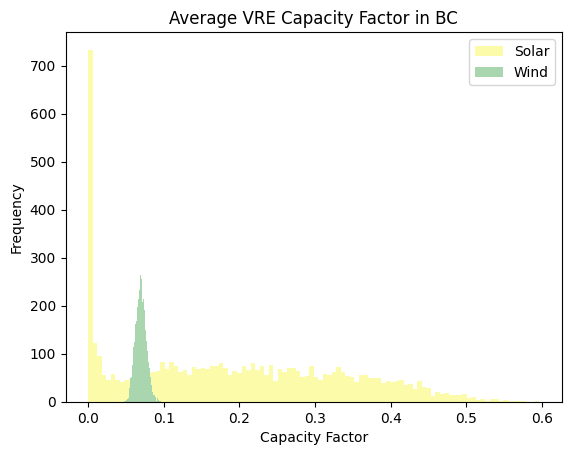

In [116]:
import matplotlib.pyplot as plt

plt.hist(cf_analysis.iloc[0:8760].loc[cf_analysis['solarcf_BC_mean'] != 0, 'solarcf_BC_mean'], bins=100, color='#fcfba9')
plt.hist(cf_analysis['windcf_BC_mean'].iloc[0:8760], bins=100, color='#a9d6ae')
plt.title('Average VRE Capacity Factor in BC')
plt.xlabel('Capacity Factor')
plt.ylabel('Frequency')
plt.legend(labels = ['Solar', 'Wind'])
plt.savefig('cf_BC.png', dpi=300, bbox_inches='tight')
plt.show()

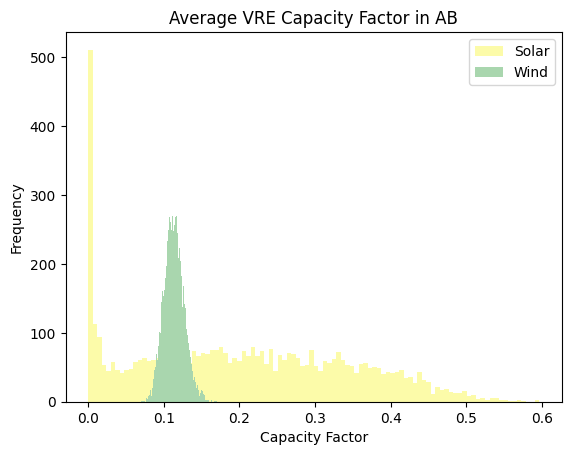

In [117]:
plt.hist(cf_analysis.iloc[0:8760].loc[cf_analysis['solarcf_AB_mean'] != 0, 'solarcf_BC_mean'], bins=100, color='#fcfba9')
plt.hist(cf_analysis['windcf_AB_mean'].iloc[0:8760], bins=100, color='#a9d6ae')
plt.title('Average VRE Capacity Factor in AB')
plt.xlabel('Capacity Factor')
plt.ylabel('Frequency')
plt.legend(labels = ['Solar', 'Wind'])
plt.savefig('cf_AB.png', dpi=300, bbox_inches='tight')
plt.show()

In [156]:
distance = pd.read_csv('distance_to_grid.csv', header=None, index_col=0)
distance_AB = distance.loc[distance.index.isin(windcf_AB.columns)]
distance_BC = distance.loc[distance.index.isin(windcf_BC.columns)]

windcf_BC_analysis = pd.DataFrame(columns=windcf_BC.columns)
windcf_BC_analysis.loc['yearly_cf'] = windcf_BC.sum()
windcf_BC_analysis.drop('mean', axis=1, inplace=True)
windcf_BC_analysis = windcf_BC_analysis.transpose()
windcf_BC_analysis = pd.concat([windcf_BC_analysis, distance_BC], axis=1)
windcf_BC_analysis.columns = ['yearly_cf', 'distance']
windcf_BC_analysis['yearly_cf'] = windcf_BC_analysis['yearly_cf'] / 8760
windcf_BC_analysis.sort_values(by='yearly_cf', ascending=False, inplace=True)

windcf_AB_analysis = pd.DataFrame(columns=windcf_AB.columns)
windcf_AB_analysis.loc['yearly_cf'] = windcf_AB.sum()
windcf_AB_analysis.drop('mean', axis=1, inplace=True)
windcf_AB_analysis = windcf_AB_analysis.transpose()
windcf_AB_analysis = pd.concat([windcf_AB_analysis, distance_AB], axis=1)
windcf_AB_analysis.columns = ['yearly_cf', 'distance']
windcf_AB_analysis['yearly_cf'] = windcf_AB_analysis['yearly_cf'] / 8760
windcf_AB_analysis.sort_values(by='yearly_cf', ascending=False, inplace=True)

windcf_BC_analysis.to_excel('windcf_BC_analysis.xlsx')
windcf_AB_analysis.to_excel('windcf_AB_analysis.xlsx')

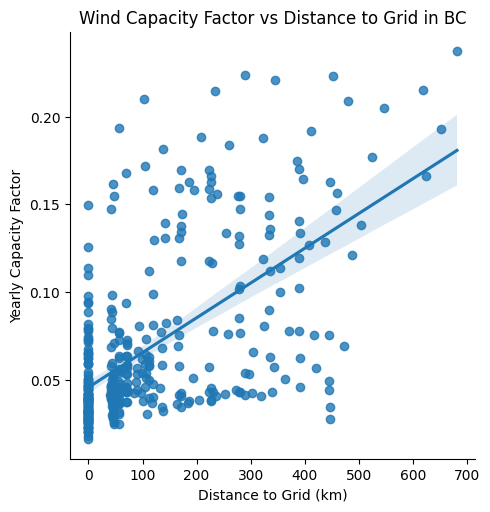

In [168]:
import seaborn as sns
sns.lmplot(x='distance', y='yearly_cf', data=windcf_BC_analysis)
plt.title('Wind Capacity Factor vs Distance to Grid in BC')
plt.xlabel('Distance to Grid (km)')
plt.ylabel('Yearly Capacity Factor')
plt.savefig('windcf_BC_analysis.jpg', dpi=300, bbox_inches='tight')

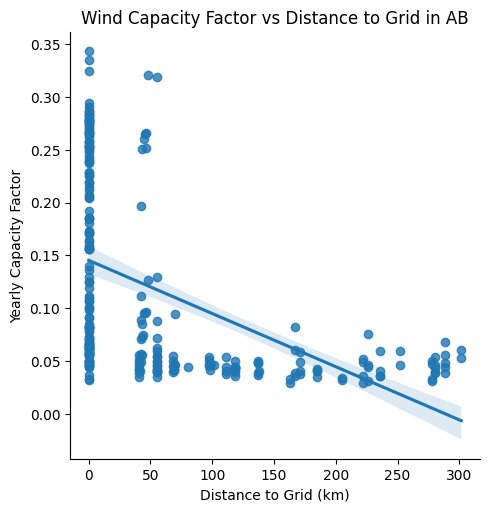

In [169]:
sns.lmplot(x='distance', y='yearly_cf', data=windcf_AB_analysis)
plt.title('Wind Capacity Factor vs Distance to Grid in AB')
plt.xlabel('Distance to Grid (km)')
plt.ylabel('Yearly Capacity Factor')
plt.savefig('windcf_AB_analysis.jpg', dpi=300, bbox_inches='tight')